Scraping Comments

In [ ]:
# citations:
# 1) the API used is from the Google Cloud Platform's Youtube API (
# "https://console.cloud.google.com/apis/dashboard")
# 2) some of the code has been taken from
# "https://www.geeksforgeeks.org/how-to-extract-youtube-comments-using-youtube-api-python/". this code had problems
# which we fixed and corrected on our own to adapt it to our needs


# from googleapiclient.discovery import build
# import json

# # since API keys should be kept secure, we cannot share ours. so please use yours instead
# api_key = input("Please enter your API key: ")


# def video_comments(video_id):
#     # creating youtube resource object
#     youtube = build('youtube', 'v3',
#                     developerKey=api_key)

#     # retrieve youtube video results
#     request = youtube.commentThreads().list(
#         part='snippet,replies',
#         videoId=video_id
#     )

#     i = 0
#     storing_dict = {}

#     # iterate video response
#     while request:

#         response = request.execute()

#         # extracting required info
#         # from each result object
#         for item in response['items']:
#             # Extracting comments
#             comment = item['snippet']['topLevelComment']['snippet']['textDisplay']

#             # this process takes a while, so we keep printing which comment number we are at
#             print(i)
#             storing_dict[i] = comment

#             i += 1

#         # Again repeat
#         request = youtube.commentThreads().list_next(
#             request, response)

#         # We need 20000 comments, so we break here. Youtube only allows us to scrape ~20000 comments so we felt this
#         # number was safe
#         if i > 20000:
#             break

#     json_object = json.dumps(storing_dict, indent=4)

#     # Writing to sample.json
#     with open("comments-jb.json", "w") as outfile:
#         outfile.write(json_object)


# # Enter video ID
# video_ID = "kffacxfA7G4"

# # Call function
# video_comments(video_ID)

Initial Cleaning of Comments

In [ ]:
# removes <br> tags
# removes &#39; and \u2019
# removes unicode
# removes <a> tags
# removes multiple spaces

# import json
# import re

# with open('comments-jb.json') as f:
#     data = json.load(f)

# storing_dict = {}
# k = 0

# for i in range(0, len(data)):
#     string = data[f"{i}"]
#     string = string.replace("<br>", "")
#     string = string.replace("&#39;", "'")
#     string = string.replace("\u2019", "'")
#     string = string.replace('\r', '')
#     string = string.replace('&lt;', '')
#     string = string.replace('&gt;', '')
#     string = string.replace('&quot;', '')
#     string = string.encode("ascii", "ignore")
#     string = string.decode('utf-8')
#     string = re.sub('<[^<]*?/?>', '', string)
#     string = re.sub(r'http\S+', '', string)
#     string = string.lstrip()
#     string = string.rstrip()
#     if string != "":
#         storing_dict[k] = string
#         k += 1

# json_object = json.dumps(storing_dict, indent=4)

# with open("comments-jb-final.json", "w") as outfile:
#     outfile.write(json_object)


Assigning Polarity to the Comments

In [ ]:
# import pandas as pd
# import json
# import nltk
# from nltk.sentiment.vader import SentimentIntensityAnalyzer

# nltk.download('vader_lexicon')

# with open('comments-jb-final.json') as f:
#     data = json.load(f)

# # polarity_list_vader contains tuples of the comment and its assigned polarity score (from +1, -1 and 0)
# polarity_list_vader = []
# # we wanted to see what the ratio of positive to negative to neutral comments was, so we took a count
# positive, negative, neutral = 0, 0, 0

# for item in data:
#     # made a SentimentIntensityAnalyzer object
#     analyzer_vader = SentimentIntensityAnalyzer()
#     # collected the score outputted by VADER. this has a positive, negative, neutral and compound score. we only use
#     # the compound score
#     sentiment_object_vader = analyzer_vader.polarity_scores(data[item])
#     if sentiment_object_vader["compound"] > 0:
#         value = 1
#         positive += 1
#     elif sentiment_object_vader["compound"] < 0:
#         value = -1
#         negative += 1
#     elif sentiment_object_vader["compound"] == 0:
#         value = 0
#         neutral += 1
#     polarity_list_vader.append([value, str(data[item])])
#     print(item)

# # made a DataFrame using the tuples in the list
# sentiment_df = pd.DataFrame(polarity_list_vader, columns=["polarity", "comment"])

# # saved the DataFrame into a csv
# sentiment_df.to_csv("polarity-limits.csv", sep=",")

# print("positive:", positive)
# print("negative:", negative)
# print("neutral:", neutral)

Cleaning the Comments and then Generating the Corpus

In [ ]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import pandas as pd

dataset = pd.read_csv('polarity-limits.csv', index_col=0)
# we did random sampling of our dataset and thus, randomly chose 25% of the comments scraped for faster results.
# reducing the dataset size by choosing 25% of the comments did not affect the accuracy of our models as ~5000
# comments is also a large dataset
dataset = dataset.sample(frac=0.25)
dataset = dataset.reset_index()

# corpus will be filled with all comments from unique words
corpus = []

for i in range(0, len(dataset)):
    # if the comment is "" after initial cleaning, just append "" to the corpus
    if str(dataset['comment'][i]) == "":
        corpus.append("")
        continue
    # all comments in lowercase
    comment = (str(dataset['comment'][i])).lower()
    # comments only have alphabetical characters from a to z. everything else, including numbers and punctuation is
    # removed
    comment = re.sub('[^a-z]', ' ', comment)

    # words like "niceeeeeee" and "aaaaaaaaaaa" are converted to "nicee" and "aa" using these lines of code
    repeat_pattern = re.compile(r'(\w)(\1)\1*')
    match_substitution = r'\1\2'
    comment = repeat_pattern.sub(match_substitution, comment)

    # splitting the comments into a list of words
    comment = comment.split()
    # made a Snowball Stemmer object
    snow_stemmer = SnowballStemmer(language='english')
    # got the list of nltk suggested stopwords
    all_stopwords = stopwords.words('english')
    # removed the stopwords we think will prove useful to us from all_stopwords
    stopwords_remove = ["not, ""don'", "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
                        'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
                        'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn',
                        "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

    all_stopwords = [word for word in all_stopwords if word not in stopwords_remove]
    # removed stopwords and stemmed the words
    comment = [snow_stemmer.stem(word) for word in comment if not word in set(all_stopwords)]
    # made a comment from the leftover words
    comment = ' '.join(comment)
    # appended the comment to the corpus
    corpus.append(comment)

print(corpus)

Vectorising the Elements of the corpus

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# creating a TFIDF vectorizer object
vectorObj = TfidfVectorizer(use_idf=True)

# X are the features which are generated by using vectorObj 
X = vectorObj.fit_transform(corpus).toarray()
# y are the labels
y = dataset.iloc[:, -2].values

Splitting the Data into Training Data and Test Data

In [ ]:
from sklearn.model_selection import train_test_split

# splitting our data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state = 0)

In [ ]:
# list which will keep track of accuracy score
accuracyList = []
# list which will keep track of f1 score
f1List = []

Training the Machine Learning Model:
**NAIVE BAYES**

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB

# made a GaussianNB classifier object
classifier = GaussianNB()
# training the model based on the features and corresponding output
classifier.fit(X_train, y_train)
# storing our predictions in y_pred
y_pred = classifier.predict(X_test)
# made a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm, end="\n\n")
# calculated the accuracy score and printed it in the percentage format
ac = accuracy_score(y_test, y_pred)
print("accuracy (%):\n" + str(ac * 100) + " %", end="\n\n")
# calculated the f1 score
f1 = f1_score(y_test, y_pred, average='macro')
print("f1 score [0, 1]:\n", f1, end="\n\n")

# kept track of accuracy score
accuracyList.append(ac * 100)
# kept track of f1 score
f1List.append(f1)

# printing the predictions of our classifier
# print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

confusion matrix:
 [[ 66  10  60]
 [ 30  40 136]
 [ 17   7 105]]

accuracy (%):
44.79830148619958 %

f1 score [0, 1]:
 0.44089169481888996



Training the Machine Learning Model:
**RANDOM FOREST**

Parameter Tuning

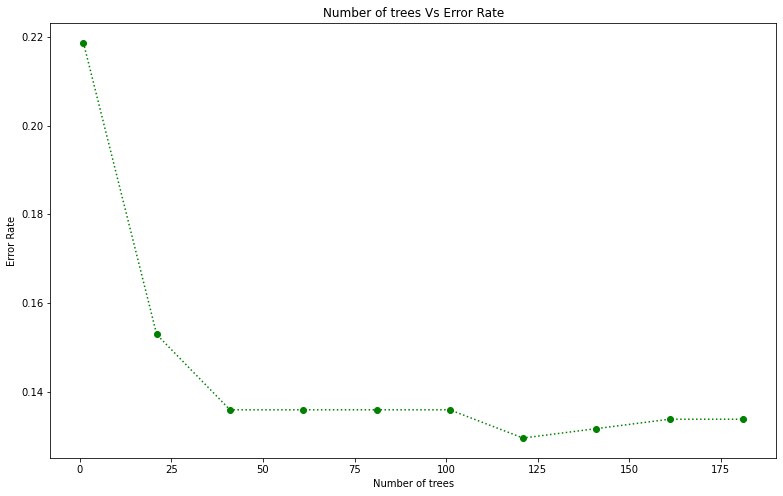

optimal value of parameter: 120


In [ ]:
# citations:
# 1) for parameter tuning, we have taken inspiration from https://analyticsindiamag.com/guide-to-multi-class-classification/


from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

# this list will store the error values
error_rate = []

steps = 20
for i in range(1,200,steps):
            # Random Forest classifier with value of n_estimators equal to i
            randomforest = RandomForestClassifier(n_estimators=i, criterion='entropy', random_state=42)
            randomforest.fit(X_train,y_train)
            pred_i = randomforest.predict(X_test)
            # calculating the error rate and storing it in error_rate
            error_rate.append(np.mean(pred_i != y_test))

# plotting the error vs value of parameter graph
plt.figure(figsize=(13,8))
plt.plot(range(1,200,steps), error_rate, linestyle = 'dotted', marker = 'o',color = 'g')
plt.xlabel('Number of trees')
plt.ylabel('Error Rate')
plt.title('Number of trees Vs Error Rate')
plt.show()

# finding the optimal paramter value by finding the index of the minimum error value in the error_rate list
optimal_parameter = error_rate.index(min(error_rate)) * steps
print("optimal value of parameter:", optimal_parameter)
# optimal_parameter = 120

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier

# made a Random Forest classifier object
classifier = RandomForestClassifier(n_estimators=optimal_parameter, criterion='entropy', random_state=42)
# training the model based on the features and corresponding output
classifier.fit(X_train, y_train)
# storing our predictions in y_pred
y_pred = classifier.predict(X_test)
# made a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm, end="\n\n")
# calculated the accuracy score and printed it in the percentage format
ac = accuracy_score(y_test, y_pred)
print("accuracy (%):\n" + str(ac * 100) + " %", end="\n\n")
# calculated the f1 score
f1 = f1_score(y_test, y_pred, average='macro')
print("f1 score [0, 1]:\n", f1, end="\n\n")

# kept track of accuracy score
accuracyList.append(ac * 100)
# kept track of f1 score
f1List.append(f1)

# printing the predictions of our classifier
# print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

confusion matrix:
 [[113  17   6]
 [  6 197   3]
 [ 15  15  99]]

accuracy (%):
86.83651804670913 %

f1 score [0, 1]:
 0.8594090671495008



Training the Machine Learning Model:
**K NEAREST NEIGHBOURS**

Parameter Tuning

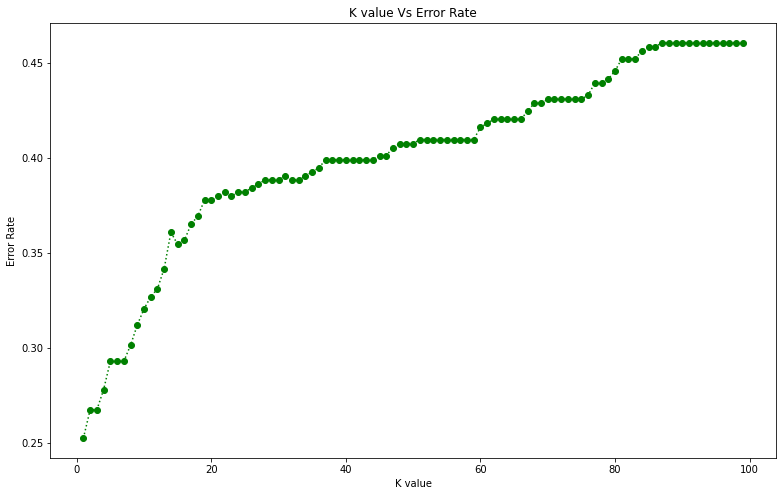

optimal value of parameter: 1


In [ ]:
# citations:
# 1) for parameter tuning, we have taken inspiration from https://analyticsindiamag.com/guide-to-multi-class-classification/


from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np

# this list will store the error values
error_rate = []

for i in range(1,100):
            # KNN classifier with value of n_neighbors equal to i
            knn = KNeighborsClassifier(n_neighbors=i)
            knn.fit(X_train,y_train)
            pred_i = knn.predict(X_test)
            # calculating the error rate and storing it in error_rate
            error_rate.append(np.mean(pred_i != y_test))

# plotting the error vs value of parameter graph
plt.figure(figsize=(13,8))
plt.plot(range(1,100), error_rate, linestyle = 'dotted', marker = 'o',color = 'g')
plt.xlabel('K value')
plt.ylabel('Error Rate')
plt.title('K value Vs Error Rate')
plt.show()

# finding the optimal paramter value by finding the index of the minimum error value in the error_rate list
optimal_parameter = error_rate.index(min(error_rate)) + 1
print("optimal value of parameter:", optimal_parameter)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

# made a KNN classifier object
classifier = KNeighborsClassifier(n_neighbors = optimal_parameter)
# training the model based on the features and corresponding output
classifier.fit(X_train, y_train)
# storing our predictions in y_pred
y_pred = classifier.predict(X_test)
# made a confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("confusion matrix:\n", cm, end="\n\n")
# calculated the accuracy score and printed it in the percentage format
ac = accuracy_score(y_test, y_pred)
print("accuracy (%):\n" + str(ac * 100) + " %", end="\n\n")
# calculated the f1 score
f1 = f1_score(y_test, y_pred, average='macro')
print("f1 score [0, 1]:\n", f1, end="\n\n")

# kept track of accuracy score
accuracyList.append(ac * 100)
# kept track of f1 score
f1List.append(f1)

# printing the predictions of our classifier
# print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

confusion matrix:
 [[ 84  45   7]
 [  8 192   6]
 [  9  44  76]]

accuracy (%):
74.73460721868365 %

f1 score [0, 1]:
 0.7315364975365782



Visualisations

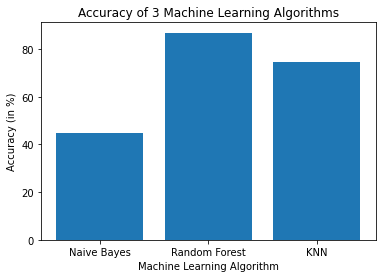

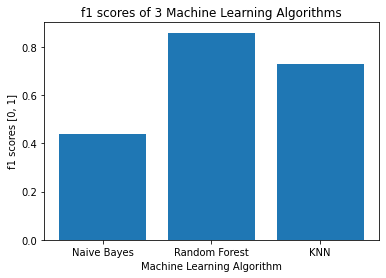

In [ ]:
import matplotlib.pyplot as plt

# plotting the graphs of the results

algorithmNames = ["Naive Bayes", "Random Forest", "KNN"]

plt.bar(algorithmNames, accuracyList[0:3])
plt.title("Accuracy of 3 Machine Learning Algorithms")
plt.xlabel("Machine Learning Algorithm")
plt.ylabel("Accuracy (in %)")
plt.show()

plt.bar(algorithmNames, f1List[0:3])
plt.title("f1 scores of 3 Machine Learning Algorithms")
plt.xlabel("Machine Learning Algorithm")
plt.ylabel("f1 scores [0, 1]")
plt.show()
